# Setup

In [3]:
from datetime import date, datetime
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import time

In [4]:
import torch
import transformers
from transformers import pipeline

# Execute Sentiment Analysis in Batches

In [3]:
csv_reviews = pd.read_csv("reviews.csv")

/var/folders/sx/5y812tj93qvbxkbmjcc6jjk80000gn/T/ipykernel_35878/1645527734.py:1: DtypeWarning: Columns (0,4,5,6,7,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  csv_reviews = pd.read_csv("reviews.csv")


In [ ]:
sentiment_pipeline = pipeline(model="distilbert-base-uncased-finetuned-sst-2-english", revision="af0f99b")
start = 3_500_000
end = (3_675_881 - 1)

review_batch = list(csv_reviews.loc[start:end]['text'].values)
for i in range(len(review_batch)):
    if i % 100_000 == 0:
        print(f"Review {i}")
    if type(review_batch[i]) != str:
        review_batch[i] = ""
 
start_time= time.time()
res = sentiment_pipeline(review_batch, truncation=True)
end_time = time.time()
print(end_time - start_time)


In [ ]:
import json
filename = f"{start}_to_{end}.json"
with open(filename, "w") as f:
    json.dump(res, f)

# Post Processing

In [ ]:
def load_sentiment(filepath):
    with open(filepath, "r") as f:
        res = json.load(f)
        labels = [x['label'] for x in res]
        confidence_scores = [x['score'] for x in res]
    
    return labels, confidence_scores

labels1, scores1 = load_sentiment("0_to_499999.json")
labels2, scores2 = load_sentiment("500000_to_999999.json")
labels3, scores3 = load_sentiment("1000000_to_1499999.json")
labels4, scores4 = load_sentiment("1500000_to_1999999.json")
labels5, scores5 = load_sentiment("2000000_to_2499999.json")
labels6, scores6 = load_sentiment("2500000_to_2999999.json")
labels7, scores7 = load_sentiment("3000000_to_3499999.json")
labels8, scores8 = load_sentiment("3500000_to_3675880.json")

labels = labels1 + labels2 + labels3 + labels4 + labels5 + labels6 + labels7 + labels8
confidence_scores = scores1 + scores2 + scores3 + scores4 + scores5 + scores6 + scores7 + scores8

In [ ]:
sentiment_df = pd.DataFrame({"sentiment":labels, "confidence_score":scores})
csv_reviews = csv_reviews.join(sentiment_df)

In [ ]:
indices_to_check = [0, 499999, 500000, 999999, 1000000, 1499999, 1500000, 1999999,
                   2000000, 2499999, 2500000, 2999999, 3000000, 3499999, 3500000, 3675879]

sentiment_res = sentiment_pipeline(list(csv_reviews.loc[indices_to_check].text.values), truncation=True) 
df_res = csv_reviews.loc[indices_to_check][['sentiment', 'confidence_score']]


for idx in range(len(indices_to_check)):
    if not (sentiment_res[idx]['label'] == df_res.loc[indices_to_check[idx]]['sentiment']):
        print("Error")
    abs_score_diff = abs(sentiment_res[idx]['score']-df_res.loc[indices_to_check[idx]]['confidence_score'])
    if abs_score_diff > 1e-15:
        print("Error")
     
print("Finished")

In [ ]:
# rename original date field as datetime
csv_reviews = csv_reviews.rename(columns={"date": "datetime"})

In [ ]:
datetime.fromisoformat(csv_reviews.loc[0].datetime).date().strftime("%y")

In [ ]:
# Remove invalid rows
def review_to_date(review):
    date = datetime.fromisoformat(review.datetime).date()   
    return date.strftime("%m-%d-%Y")


def is_valid_review(review):
    if type(review['text']) != str:
        return False
    
    try:
        review_to_date(review)
        return True
    except:
        print("Exception")
        return False

csv_reviews = csv_reviews[csv_reviews.apply(is_valid_review, axis=1)]

In [ ]:
# create new date field 
csv_reviews['date'] = csv_reviews.apply(review_to_date, axis = 1)

In [ ]:
# create new year-month field
def review_to_year_month(review):
    date = datetime.fromisoformat(review.datetime).date()   
    return date.strftime("%Y-%m")

csv_reviews['year_month'] = csv_reviews.apply(review_to_year_month, axis = 1)

In [ ]:
# create new year field
def year(review):
    return datetime.fromisoformat(review.datetime).year

csv_reviews['year'] = csv_reviews.apply(year, axis = 1)

In [ ]:
csv_reviews.to_csv("reviews_with_sentiment.csv", index=False)

# Analyze Sentiment Across Time

In [5]:
reviews = pd.read_csv("reviews_with_sentiment.csv")

/var/folders/sx/5y812tj93qvbxkbmjcc6jjk80000gn/T/ipykernel_45413/617990225.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews = pd.read_csv("reviews_with_sentiment.csv")


In [6]:
reviews_asian = reviews[reviews.apply(lambda x: x['cuisine'] == "Asian", axis=1)]
reviews_eur = reviews[reviews.apply(lambda x: x['cuisine'] == "American European", axis=1)]
reviews_both = reviews[reviews.apply(lambda x: x['cuisine'] == "Both", axis=1)]

### Aggregate

In [7]:
# Aggregate positive and negative sentiment
num_pos_asian = len(reviews[reviews.apply(lambda x: x['cuisine'] == "Asian" 
                                          and x['sentiment'] == "POSITIVE", axis=1)])
num_neg_asian = len(reviews[reviews.apply(lambda x: x['cuisine'] == "Asian" 
                                          and x['sentiment'] == "NEGATIVE", axis=1)])

num_pos_eur = len(reviews[reviews.apply(lambda x: x['cuisine'] == "American European" 
                                        and x['sentiment'] == "POSITIVE", axis=1)])
num_neg_eur = len(reviews[reviews.apply(lambda x: x['cuisine'] == "American European" 
                                        and x['sentiment'] == "NEGATIVE", axis=1)])

num_pos_both = len(reviews[reviews.apply(lambda x: x['cuisine'] == "Both" 
                                         and x['sentiment'] == "POSITIVE", axis=1)])
num_neg_both = len(reviews[reviews.apply(lambda x: x['cuisine'] == "Both" 
                                         and x['sentiment'] == "NEGATIVE", axis=1)])


In [8]:
mean_sentiment_asian = num_pos_asian / (num_pos_asian + num_neg_asian)
mean_sentiment_eur = num_pos_eur / (num_pos_eur + num_neg_eur)
mean_sentiment_both = num_pos_both / (num_pos_both + num_neg_both)

print(f"Mean Asian Sentiment: {mean_sentiment_asian}")
print(f"Mean European + American Sentiment: {mean_sentiment_eur}")
print(f"Mean Both Sentiment: {mean_sentiment_both}")

Mean Asian Sentiment: 0.7351414048278979
Mean European + American Sentiment: 0.7030905210612681
Mean Both Sentiment: 0.7600773109929971


### Across Time

In [12]:
def percent_pos_sentiment(df):
    num_pos = len(df[df["sentiment"] == "POSITIVE"])
    num_neg = len(df[df["sentiment"] == "NEGATIVE"]) 
    return num_pos / (num_pos + num_neg)
    
# pps stands for percent positive sentiment
pps_by_year_asian = reviews_asian.groupby(["year"]).apply(percent_pos_sentiment)
pps_by_year_eur = reviews_eur.groupby(["year"]).apply(percent_pos_sentiment)
pps_by_year_both = reviews_both.groupby(["year"]).apply(percent_pos_sentiment)

NameError: name 'reviews_both' is not defined

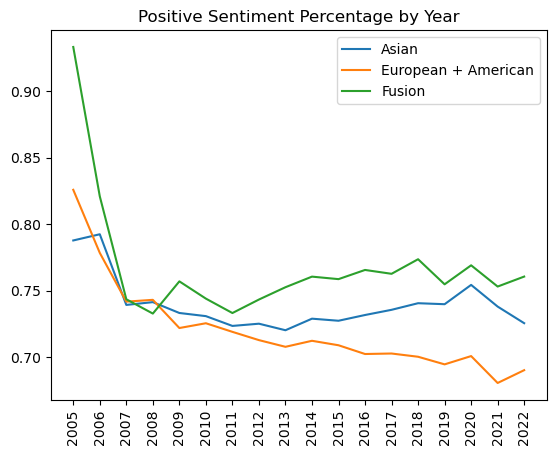

In [10]:
plt.plot(pps_by_year_asian, label="Asian")
plt.plot(pps_by_year_eur, label="European + American")
plt.plot(pps_by_year_both, label="Fusion")
plt.xticks(pps_by_year_asian.keys(), rotation="vertical")
plt.legend()
plt.title("Positive Sentiment Percentage by Year")
plt.show()

In [11]:
# pps stands for percent positive sentiment
pps_by_year_month_asian = reviews_asian.groupby(["year_month"]).apply(percent_pos_sentiment)
pps_by_year_month_eur = reviews_eur.groupby(["year_month"]).apply(percent_pos_sentiment)
pps_by_year_month_both = reviews_both.groupby(["year_month"]).apply(percent_pos_sentiment)

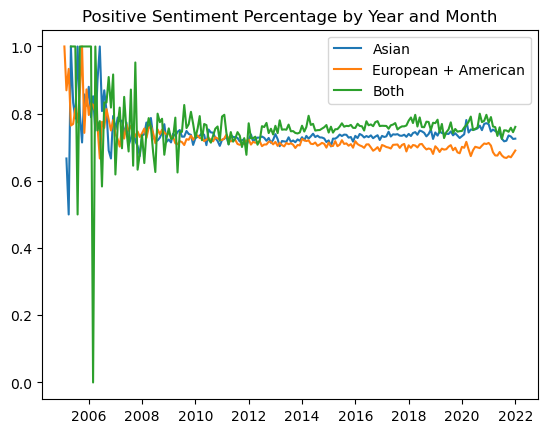

In [12]:
def plot_year_month(x, label):
    dates = pd.to_datetime(x.keys())
    values = x.values
    plt.plot(dates, values, label=label)


plot_year_month(pps_by_year_month_asian, label="Asian")
plot_year_month(pps_by_year_month_eur, label="European + American")
plot_year_month(pps_by_year_month_both, label="Both")
plt.legend()
plt.title("Positive Sentiment Percentage by Year and Month")
plt.show()


In [13]:
reviews_count_asian = reviews_asian.groupby("year_month")["year_month"].count()
reviews_count_eur = reviews_eur.groupby("year_month")["year_month"].count()
reviews_count_both = reviews_both.groupby("year_month")["year_month"].count()

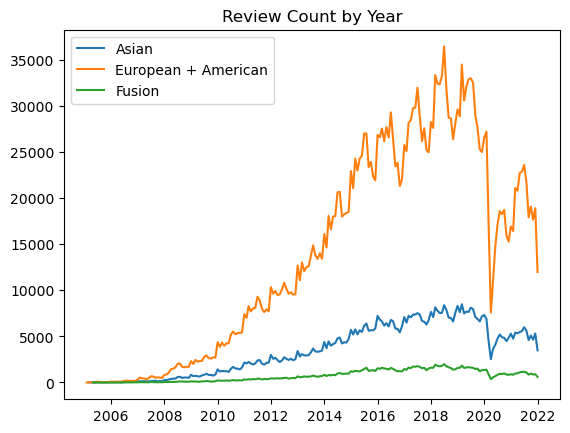

In [14]:
plot_year_month(reviews_count_asian, label="Asian")
plot_year_month(reviews_count_eur, label="European + American")
plot_year_month(reviews_count_both, label="Fusion")
# plot_year_month(pps_by_year_month_both, label="Both")
plt.legend()
plt.title("Review Count by Year")
plt.show()


# Analyze Sentiment Across Time for Two Categories

In [6]:
reviews_asian = reviews[reviews.apply(lambda x: x['cuisine'] != "American European", axis=1)]
reviews_eur = reviews[reviews.apply(lambda x: x['cuisine'] == "American European", axis=1)]


In [7]:
# Start looking at data from 2010 onwards
reviews_asian = reviews_asian[reviews_asian["year"] >= 2010]
reviews_asian = reviews_asian[reviews_asian["year"] <= 2021]

reviews_eur = reviews_eur[reviews_eur["year"] >= 2010]
reviews_eur = reviews_eur[reviews_eur["year"] <= 2021]

In [17]:
# Aggregate positive and negative sentiment

num_pos_asian = len(reviews_asian[reviews_asian["sentiment"] == "POSITIVE"])
num_neg_asian = len(reviews_asian[reviews_asian["sentiment"] == "NEGATIVE"])


num_pos_eur = len(reviews_eur[reviews_eur["sentiment"] == "POSITIVE"])
num_neg_eur = len(reviews_eur[reviews_eur["sentiment"] == "NEGATIVE"])

mean_sentiment_asian = num_pos_asian / (num_pos_asian + num_neg_asian)
mean_sentiment_eur = num_pos_eur / (num_pos_eur + num_neg_eur)

print(f"Mean Asian Sentiment: {mean_sentiment_asian}")
print(f"Mean European + American Sentiment: {mean_sentiment_eur}")


Mean Asian Sentiment: 0.7394192208536235
Mean European + American Sentiment: 0.7025295920206693


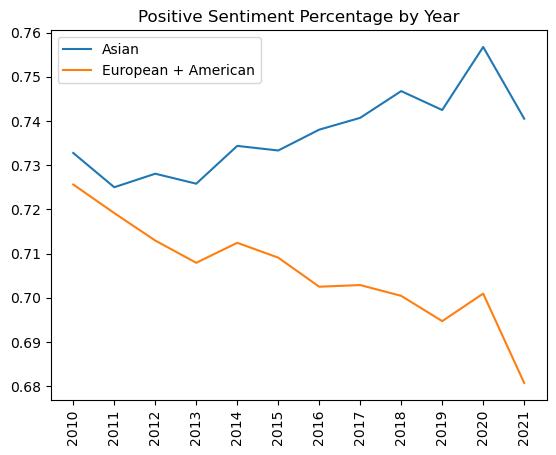

In [13]:
def percent_pos_sentiment(df):
    num_pos = len(df[df["sentiment"] == "POSITIVE"])
    num_neg = len(df[df["sentiment"] == "NEGATIVE"]) 
    return num_pos / (num_pos + num_neg)
    
# pps stands for percent positive sentiment
pps_by_year_asian = reviews_asian.groupby(["year"]).apply(percent_pos_sentiment)
pps_by_year_eur = reviews_eur.groupby(["year"]).apply(percent_pos_sentiment)

plt.plot(pps_by_year_asian, label="Asian")
plt.plot(pps_by_year_eur, label="European + American")
plt.xticks(pps_by_year_asian.keys(), rotation="vertical")
plt.legend()
plt.title("Positive Sentiment Percentage by Year")
plt.show()

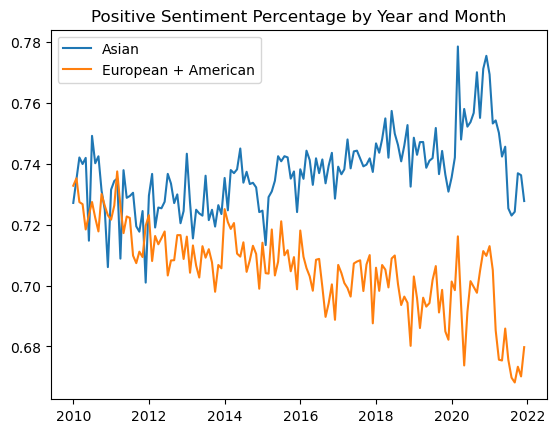

In [14]:
# pps stands for percent positive sentiment
pps_by_year_month_asian = reviews_asian.groupby(["year_month"]).apply(percent_pos_sentiment)
pps_by_year_month_eur = reviews_eur.groupby(["year_month"]).apply(percent_pos_sentiment)

def plot_year_month(x, label):
    dates = pd.to_datetime(x.keys())
    values = x.values
    plt.plot(dates, values, label=label)


plot_year_month(pps_by_year_month_asian, label="Asian")
plot_year_month(pps_by_year_month_eur, label="European + American")
plt.legend()
plt.title("Positive Sentiment Percentage by Year and Month")
plt.show()

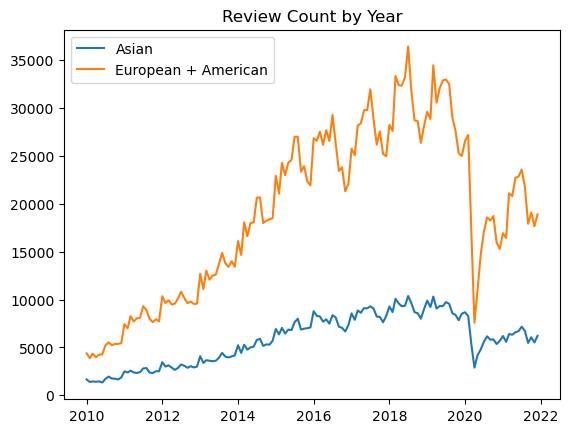

In [20]:
reviews_count_asian = reviews_asian.groupby("year_month")["year_month"].count()
reviews_count_eur = reviews_eur.groupby("year_month")["year_month"].count()

plot_year_month(reviews_count_asian, label="Asian")
plot_year_month(reviews_count_eur, label="European + American")

plt.legend()
plt.title("Review Count by Year")
plt.show()


# Correlational Analysis of Sentiment Over Time

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

In [8]:
from scipy import stats

In [9]:
# Difference between sentiment
def pps_diffs(pps_asian, pps_eur):
    pps_diffs = []
    for i in range(len(pps_asian)):
        pps_diffs.append((pps_asian[i] - pps_eur[i]) * 100)  
    return pps_diffs

def regress(time, pps_asian, pps_eur):
    pps_diffs = []
    for i in range(len(pps_asian)):
        pps_diffs.append((pps_asian[i] - pps_eur[i]) * 100)  
    return stats.linregress(years, pps_diffs)


In [23]:
# plotting code copied and then changed from 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
def plot_with_regression_line(time, values, ln, title=None, xaxis=None, yaxis=None, 
                              color="cadetblue", data_label="data", line_label="regression line"):
    regression_values = [ln.intercept + ln.slope*x for x in time]
    plt.plot(time, values, color=color, marker="o", linestyle="none",label=data_label)    
    plt.plot(time, regression_values, 'black', label=line_label)
    plt.legend()
    if title:
        plt.title(title)
    if xaxis:
        plt.xlabel(xaxis)
    if yaxis:
        plt.ylabel(yaxis)


LinregressResult(slope=0.509983660570012, intercept=-1024.7454707243667, rvalue=0.9918210023425513, pvalue=2.843292803820674e-10, stderr=0.02075382531855828, intercept_stderr=41.8293962831233)


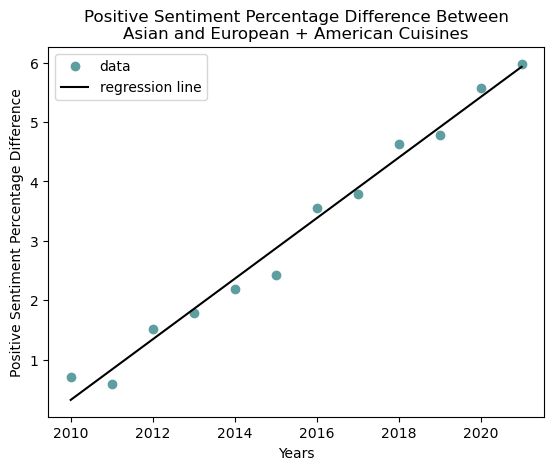

In [260]:
# Difference in Positive Sentiment Percentage Difference (Years)
years = list(pps_by_year_asian.keys())
diffs = pps_diffs(list(pps_by_year_asian.values), list(pps_by_year_eur.values))
ln = stats.linregress(years, diffs)
print(ln)
plot_with_regression_line(years, diffs, ln, 
"Positive Sentiment Percentage Difference Between\nAsian and European + \
American Cuisines",
"Years",
"Positive Sentiment Percentage Difference"
)


LinregressResult(slope=0.5185952730712232, intercept=-1042.3254734339948, rvalue=0.889279424607565, pvalue=4.2898333259025065e-50, stderr=0.022382490152477477, intercept_stderr=45.122234156307336)


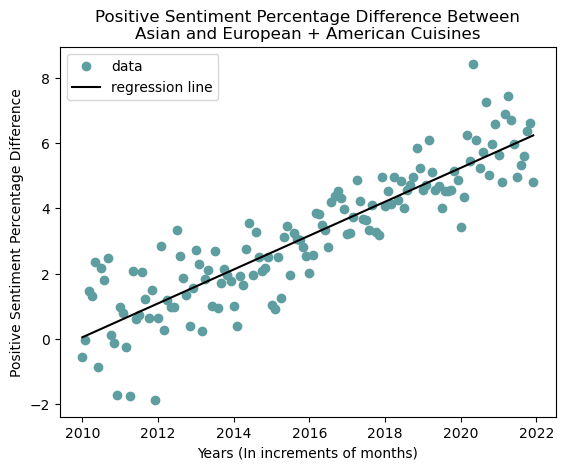

In [20]:
# Difference in Positive Sentiment Percentage Difference (Years and Months)
def year_month_str_to_num(year_month):
    year, month = year_month.split("-")
    return int(year) + (int(month) - 1) /(12)

year_months = [year_month_str_to_num(x) for x in list(pps_by_year_month_asian.keys())]
diffs = pps_diffs(list(pps_by_year_month_asian.values), list(pps_by_year_month_eur.values))
ln = stats.linregress(year_months, diffs)
print(ln)
plot_with_regression_line(year_months, diffs, ln, 
"Positive Sentiment Percentage Difference Between\nAsian and European + \
American Cuisines",
"Years (In increments of months)",
"Positive Sentiment Percentage Difference"
)

LinregressResult(slope=0.20992609207757892, intercept=-349.40026336586834, rvalue=0.8234353282577996, pvalue=0.0009965450147235058, stderr=0.045743986875976916, intercept_stderr=92.19714077935356)


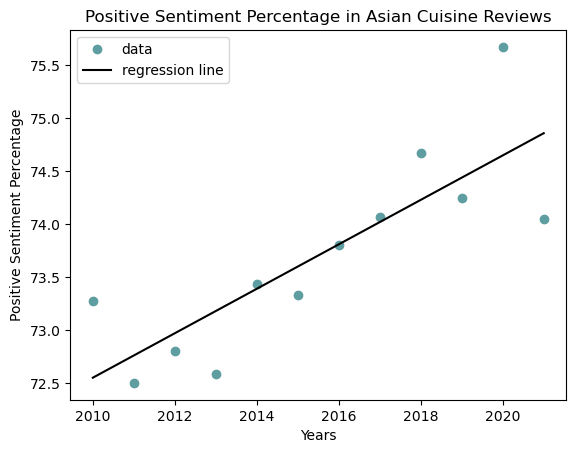

In [251]:
# Asian Positive Sentiment Percentage by year
years = list(pps_by_year_asian.keys())
pps = list(pps_by_year_asian.values * 100)
ln = stats.linregress(years, pps)
print(ln)
plot_with_regression_line(years, pps, ln, 
"Positive Sentiment Percentage in Asian Cuisine Reviews",
"Years",
"Positive Sentiment Percentage"
)

LinregressResult(slope=0.2083139558569778, intercept=-346.24316759889155, rvalue=0.5746351837535303, pvalue=5.029999816339036e-14, stderr=0.024897327866863384, intercept_stderr=50.19204968802883)


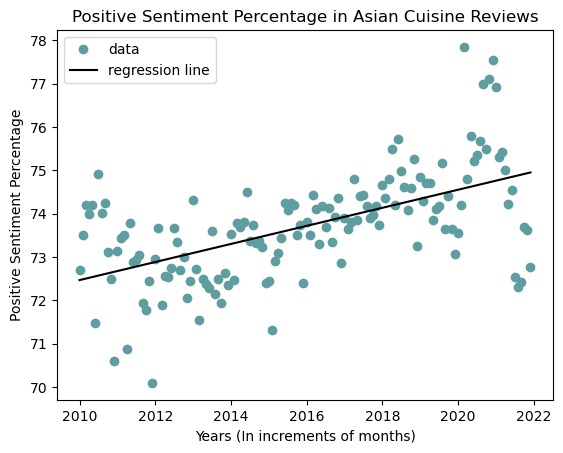

In [252]:
# Asian Positive Sentiment Percentage by years and months
year_months = [year_month_str_to_num(x) for x in list(pps_by_year_month_asian.keys())]
pps = list(pps_by_year_month_asian.values * 100)
ln = stats.linregress(year_months, pps)
print(ln)
plot_with_regression_line(year_months, pps, ln, 
"Positive Sentiment Percentage in Asian Cuisine Reviews",
"Years (In increments of months)",
"Positive Sentiment Percentage"
)

In [1]:
# European + American Positive Sentiment Percentage by Year
years = list(pps_by_year_eur.keys())
pps = list(pps_by_year_eur.values * 100)
ln = stats.linregress(years, pps)
print(ln)
plot_with_regression_line(years, pps, ln, 
"Positive Sentiment Percentage in \nEuropean + American Cuisine Reviews",
"Years",
"Positive Sentiment Percentage"
)

NameError: name 'pps_by_year_eur' is not defined

LinregressResult(slope=-0.3102813172142456, intercept=696.0823058351035, rvalue=-0.7813217242679349, pvalue=7.231124486193352e-31, stderr=0.020799627490590625, intercept_stderr=41.93124427178688)


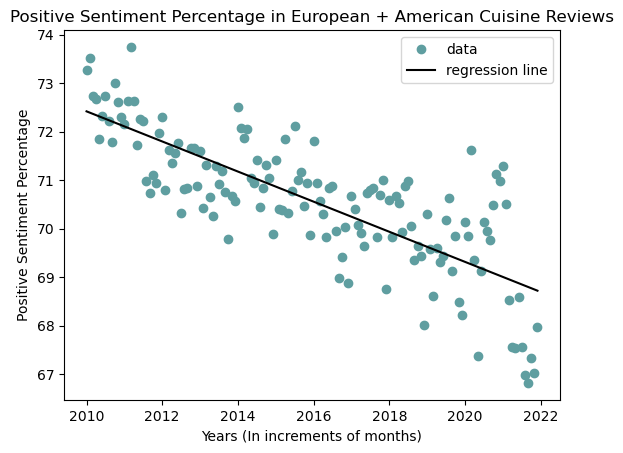

In [254]:
# European + American Positive Sentiment Percentage by Years and Months
year_months = [year_month_str_to_num(x) for x in list(pps_by_year_month_eur.keys())]
pps = list(pps_by_year_month_eur.values * 100)
ln = stats.linregress(year_months, pps)
print(ln)
plot_with_regression_line(year_months, pps, ln, 
"Positive Sentiment Percentage in European + American Cuisine Reviews",
"Years (In increments of months)",
"Positive Sentiment Percentage"
)

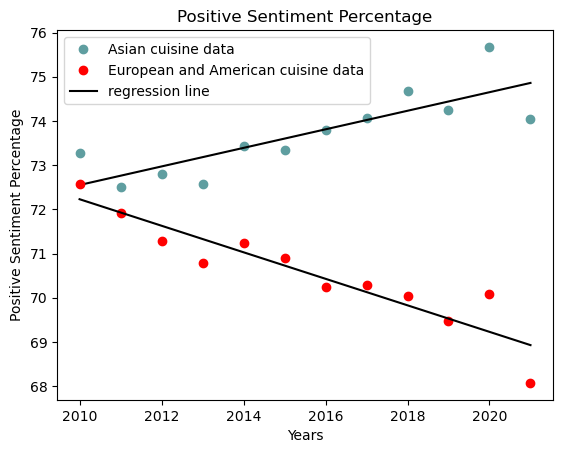

In [32]:
# Yearly for both cuisines
years = list(pps_by_year_asian.keys())
pps_asian = list(pps_by_year_asian.values * 100)
pps_eur = list(pps_by_year_eur.values * 100)
ln_asian = stats.linregress(years, pps_asian)
ln_eur = stats.linregress(years, pps_eur)
plot_with_regression_line(years, pps_asian, ln_asian, 
"Positive Sentiment Percentage",
"Years",
"Positive Sentiment Percentage",
data_label="Asian cuisine data",
line_label=None                                           
)
plot_with_regression_line(years, pps_eur, ln_eur, color="red",
data_label="European and American cuisine data",                                
)

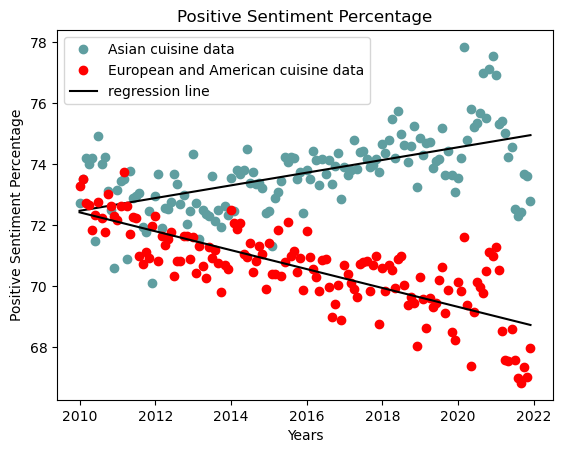

In [31]:
# Monthly for both cuisines
year_months = [year_month_str_to_num(x) for x in list(pps_by_year_month_eur.keys())]
pps_asian = list(pps_by_year_month_asian.values * 100)
pps_eur = list(pps_by_year_month_eur.values * 100)
ln_asian = stats.linregress(year_months, pps_asian)
ln_eur = stats.linregress(year_months, pps_eur)
plot_with_regression_line(year_months, pps_asian, ln_asian, 
"Positive Sentiment Percentage",
"Years",
"Positive Sentiment Percentage",
data_label="Asian cuisine data",
line_label=None                          
)
plot_with_regression_line(year_months, pps_eur, ln_eur, color="red",
data_label="European and American cuisine data",                        
)